In [65]:
# import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from pysmiles import read_smiles
import networkx as nx 

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, max_error, r2_score
from sklearn.feature_selection import VarianceThreshold

import torch
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import SAGEConv, GATConv, GATv2Conv, Sequential, BatchNorm
from torch_geometric.nn import SAGPooling
from torch_geometric.data import Batch, Data

import re
import warnings
import seaborn as sns

In [283]:
# load and filter Tg data
# dataset from Liu et al. (2022) (https://doi.org/10.1145/3534678.3539347)
tgs = pd.read_csv("tg_raw.csv", header=0)
#tgs = tgs.drop(np.where(tgs.iloc[:,0].str.contains("\[[0-9A-Z]+\]") == True)[0]) # drop all rows with non-major isotopes (eg 2H)
tgs = tgs.drop(np.where(tgs.iloc[:,0].str.contains("\[[^\]]*\]") == True)[0]) # drop all rows with nonconventional atoms
tgs.reset_index(drop=True)

,SMILES,tg
0,*C*,-54.0
1,*CC(*)C,-3.0
2,*CC(*)CC,-24.1
3,*CC(*)CCC,-37.0
4,*CC(*)C(C)C,60.0
...,...,...
6400,*CC(*)(F)C(=O)OCCC,62.0
6401,*CC(F)(F)C1(F)C(*)CC(O)(C(F)(F)F)C1(F)F,152.0
6402,*CC(F)(F)C1(F)CC(CC(O)(C(F)(F)F)C(F)(F)F)CC1*,98.0
6403,*CC(F)(F)C1(F)CC(C(O)(C(F)(F)F)C(F)(F)F)CC1*,118.0


In [3]:
# check for missing values
any(tgs.iloc[:,1] == None)

False

In [4]:
# map elements to atomic number. Connection points "*" are assigned a value of 0
atomdict = {None:0, 'H':1, 'Li':3, 'B':5, 'C':6, 'N':7, 'O':8, 'F':9, 'Na':11, 'Si':14, 'P':15, 'S':16, 'Cl':17, 
            'Ca':20, 'Cu':29, 'Zn':30, 'Ge':32, 'Se':34, 'Br':35, 'Cd':48, 'Sn':50, 'Te':52, 'I':53, 'Pb':82}

# convert SMILES notation to a Pytorch Geometric graph via networkx
def smiles_to_graph(smiles):
    graph = read_smiles(smiles)
    assignments = dict(zip(list(graph.nodes), 
                           [atomdict[atom[1]] for atom in list(graph.nodes(data="element"))]))
    nx.set_node_attributes(graph, assignments, "element")
    return from_networkx(graph, 
                         group_node_attrs=all,
                         group_edge_attrs=all) #this is a pyg graph

In [5]:
# smoothing function for plotting loss curves
# m is the modified Z-score (3.5 discards ~0.05% of the data)
def smoother(x, m=3.5, win=3):
    x_corr = np.copy(x)
    diff = np.abs(x - np.median(x))
    mdev = np.median(diff)
    idxs_outliers = np.nonzero(diff > m*mdev)[0]
    for i in idxs_outliers:
        if i-win < 0:
            x_corr[i] = np.median(np.append(x[0:i], x[i+1:i+win+1]))
        elif i+win+1 > len(x):
            x_corr[i] = np.median(np.append(x[i-win:i], x[i+1:len(x)]))
        else:
            x_corr[i] = np.median(np.append(x[i-win:i], x[i+1:i+win+1]))
    return x_corr

In [6]:
# define a dataset class that performs the train/test split automatically. Random state is fixed to ensure fair comparison between LinReg & GCN.
class GraphDataSet:
    def __init__(self, data, get_edge_attr, test_size = 0.2):
        self.get_edge_attr = get_edge_attr
        self.test_size = test_size

        self.polymer = list([smiles_to_graph(smiles) for smiles in list(data.iloc[:,0])]) 
        self.target = list(data.iloc[:, 1])

        rangeL = range(len(self.polymer))
        train_mask, test_mask = train_test_split(rangeL, test_size = test_size, random_state=1234)
        self.Xtrain = [self.polymer[int(i)] for i in train_mask]
        self.Xtest = [self.polymer[int(i)] for i in test_mask]
        self.Ytrain = [self.target[int(i)] for i in train_mask]
        self.Ytest = [self.target[int(i)] for i in test_mask]
 

    def get_train_batch(self, numtrain:int):
        sample_inds = np.random.choice(np.arange(len(self.Ytrain)), size = numtrain)
        return [self.Xtrain[i] for i in sample_inds], torch.tensor([self.Ytrain[i] for i in sample_inds], dtype=torch.float32)
    
    def get_test(self, test_inds = None):
        return self.Xtest, torch.tensor(np.array(self.Ytest), dtype=torch.float32)

In [7]:
# initialize the GNN. GNN architecture is modified from Queen et al. (2023) (https://doi.org/10.1038/s41524-023-01034-3)
# arguments: input_feat (number of input features - 4 for graphs from the graph dataset), hidden (desired number of nodes per hidden layer)
class GNN(torch.nn.Module):
    def __init__(self, input_feat, hidden):
        super(GNN, self).__init__()
        self.hidden = hidden

        # embedding block: considers node attributes, edges & edge attributes
        self.embed = Sequential('x, edge_index, edge_attr, batch', [
            (GATConv(input_feat, hidden, aggr = 'max'), 'x, edge_index, edge_attr -> x'),
            BatchNorm(hidden, track_running_stats=False),
            torch.nn.PReLU(),
            (SAGEConv(hidden, hidden, aggr = 'max'), 'x, edge_index -> x'),
            BatchNorm(hidden, track_running_stats=False),
            torch.nn.PReLU(),
            (SAGPooling(hidden), 'x, edge_index, batch=batch -> x'),
        ])
        
        # Prediction block: predicts Tg based on output of embedding block
        self.fc1 = torch.nn.Linear(hidden, hidden)
        self.leaky1 = torch.nn.LeakyReLU()
        self.fc2 = torch.nn.Linear(hidden, 1)

    def forward(self, polymer:torch.Tensor):
        mol_embed = self.embed(polymer.x.to(torch.float32), polymer.edge_index, 
                                polymer.edge_attr.to(torch.float32), 
                                polymer.batch)[0]
        squish = torch.squeeze(mol_embed)
        pool = torch.max(squish, dim=0)[0]
        temp = self.leaky1(self.fc1(pool))
        tg = self.fc2(temp)
        return tg

In [251]:
# arguments: model (initialized GNN model), optimizer (optimizer initialized w/ parameters), criterion (loss function), dataset (graph dataset object)
#            batch_size (number of samples to use in minibatch per epoch), epochs (number of epochs to train the model)
def train(model, optimizer, criterion, dataset, batch_size, epochs):
    # store train/test losses and best model parameters if restart from a stable state is desired
    train_loss = []
    test_loss = []
    bestparams = model.state_dict()
    
    for epoch in range(epochs):
        train_predictions = []
        cum_loss = 0
        train_batch, Ytrain = dataset.get_train_batch(numtrain=batch_size)
        test_batch, Ytest = dataset.get_test()

        # Stochastic gradient descent. Use one sample per iteration to do forward & backward passes
        for i in range(batch_size):
            prediction = model(Batch().from_data_list(train_batch)[i])
            train_predictions.append(prediction.clone().detach().item())
            loss = criterion(prediction, torch.tensor(Ytrain[i]))
            optimizer.zero_grad()
            loss.backward()
            cum_loss += loss.item()
            optimizer.step()
        
        # validate on test set every epoch, but do not update the gradient while doing so (to prevent data leakage)
        test_predictions = []
        with torch.no_grad():
            for i in range(Ytest.shape[0]):
                tp = model(Batch().from_data_list(test_batch)[i])
                test_predictions.append(tp.clone().detach().item())
        
        # get test r2 and loss on this epoch
        r2_test = r2_score(Ytest, test_predictions)
        lossfn_test = mean_absolute_error(Ytest, test_predictions)

        train_loss.append(cum_loss)
        test_loss.append(lossfn_test)
        test_r2.append(r2_test)
        # update the best model parameters based on test loss
        if len(test_loss) > 1 and lossfn_test < min(test_loss):
            bestparams = model.state_dict()

        # print progress every two epochs
        if epoch % 2 == 0:
            print(f'Epoch: {epoch}, \t Train r2: {r2_score(Ytrain, train_predictions):.4f} \t Train Loss: {cum_loss:.4f} \t Test r2: {r2_test:.4f} \t Test Loss {lossfn_test:.4f}')
        
    return train_loss, test_loss, bestparams


In [57]:
# read pandas dataframe into graph dataset object (and concurrently perform the train/test split)
%%capture # prevents warning message when discarding stereochemical information
poly_dataset = GraphDataSet(tgs, True)

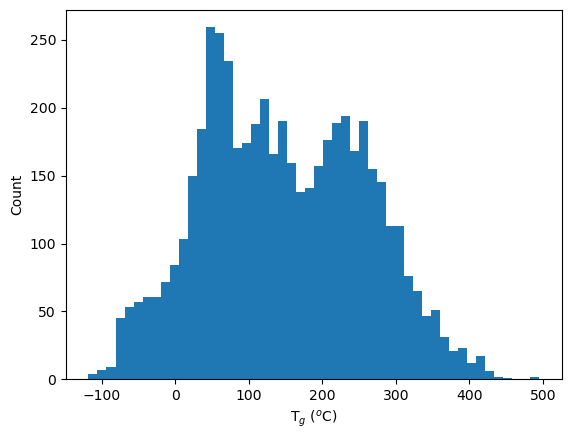

In [20]:
# plot histogram visualizing distribution of Tg.
# Note: this block has been superceded by the violin plot
counts, bins = np.histogram(poly_dataset.Ytrain, bins=50)
plt.stairs(counts, bins, fill=True)
plt.xlabel("T$_g$ ($^o$C)")
plt.ylabel("Count")
plt.show()

In [211]:
# initialize model with 4 input features and 32 nodes per hidden layer.
# if desired, dictionary of model parameters can be loaded at this stage as well (useful for training in sets of 20-50 epochs on a CPU)
model = GNN(4,32)
# model.load_state_dict(torch.load("full32_epoch200.pt"))

<All keys matched successfully>

In [215]:
# arguments: lr (learning rate), weight_decay (regularization term)
opt = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
crit = torch.nn.SmoothL1Loss()

warnings.filterwarnings("ignore")
epoch250_train, epoch250_test, best250 = train(model=model, optimizer=opt, criterion=crit, dataset=poly_dataset, batch_size=128, epochs=50)

Epoch: 0, 	 Train r2: 0.7000 	 Train Loss: 5940.0622 	 Test r2: 0.6967 	 Test Loss 45.6064
Epoch: 2, 	 Train r2: 0.7258 	 Train Loss: 5171.9735 	 Test r2: 0.7040 	 Test Loss 45.4229
Epoch: 4, 	 Train r2: 0.6767 	 Train Loss: 6299.8238 	 Test r2: 0.6953 	 Test Loss 45.5848
Epoch: 6, 	 Train r2: 0.7051 	 Train Loss: 5765.5818 	 Test r2: 0.7010 	 Test Loss 45.5664
Epoch: 8, 	 Train r2: 0.7295 	 Train Loss: 5519.6960 	 Test r2: 0.6859 	 Test Loss 46.1580
Epoch: 10, 	 Train r2: 0.7476 	 Train Loss: 5249.1523 	 Test r2: 0.7069 	 Test Loss 45.2716
Epoch: 12, 	 Train r2: 0.6953 	 Train Loss: 5895.5776 	 Test r2: 0.7032 	 Test Loss 45.2326
Epoch: 14, 	 Train r2: 0.6558 	 Train Loss: 5677.1808 	 Test r2: 0.7035 	 Test Loss 45.1151
Epoch: 16, 	 Train r2: 0.7724 	 Train Loss: 5272.3363 	 Test r2: 0.6898 	 Test Loss 45.9404
Epoch: 18, 	 Train r2: 0.5329 	 Train Loss: 6456.9410 	 Test r2: 0.7044 	 Test Loss 44.9116
Epoch: 20, 	 Train r2: 0.6864 	 Train Loss: 5804.4927 	 Test r2: 0.7020 	 Test Loss 4

In [216]:
# save model state (not required if computational resources allow continuous training)
# must be run once training is complete to record the model state before transfer learning
torch.save(model.state_dict(), "full32_epoch250.pt")

In [173]:
tt_train_20 = [12134.34591408819, 9098.305671691895, 9718.36450958252, 8545.381526947021, 9095.987846970558, 7844.001067042351, 8899.897022247314, 8854.815389633179, 7968.500745877624, 9036.605068027973, 8198.410589337349, 7893.778678894043, 8297.069767206907, 8753.034801483154, 7454.963062286377, 8785.932390213013, 7299.038788616657, 8034.119155704975, 7661.062731899321, 7941.542240142822]
tt_train_130 = [6632.322274923325, 7776.6965675354, 7828.428275676444, 7102.339878462255, 6881.383685469627, 7625.287576675415, 7817.298417981714, 6969.059876905754, 8673.372152328491, 7302.978706158698, 7267.828019425273, 7091.369888294488, 6926.845895644394, 6993.029935440049, 8079.942273810506, 6450.473222987726, 7130.652527157217, 7008.9610220864415, 6504.804753752425, 7300.87593941018, 7897.731460571289, 7441.212116241455, 6333.381348267198, 7214.795200794935, 7084.003525445238, 6619.894906997681, 6851.832240588032, 6989.060077667236, 7093.55459754914, 7524.062780896202, 6729.641698993859, 7353.6904417052865, 7851.1711711883545, 6309.386516739731, 6378.883641168475, 6998.537440009415, 7443.992076873779, 7234.949915662408, 7360.439270019531, 6146.520449637901, 6793.492781162262, 7143.241325646639, 7132.776029381901, 6708.582311630249, 6244.978443965316, 6672.794352278113, 6360.500657799654, 7213.557586453855, 7284.766104657203, 6657.462747842073, 6098.804469546303, 6214.331612788141, 7473.199435353279, 6457.635920286179, 6789.859215982258, 6711.553082674742, 6268.818294951692, 5415.955761000514, 6200.037112399936, 6048.991934508085, 6114.699593557045, 6722.956318966113, 7018.322677612305, 6913.394092559814, 6880.464645385742, 6673.460319519043, 7555.4807777404785, 7858.98615783453, 5845.152565002441, 6471.985117673874, 6660.43568572402, 7401.35643196106, 6790.579275611788, 5729.9900374580175, 6379.955263137817, 6138.614235136658, 6563.176399175078, 6190.249242812395, 6847.469476155937, 7272.248782675713, 6438.931306734681, 6472.520975112915, 6472.575527191162, 5674.440565988421, 6913.051918018144, 5967.659744434059, 6154.233615243807, 6892.382745467126, 5865.217819452286, 6613.27872562781, 5590.91810179688, 5852.153981626034, 6720.477260253858, 6581.453772589564, 6162.044904019684, 5740.783318625763, 5389.404073253274, 6289.984828898683, 5713.485842950642, 6887.223526477814, 5841.500185647979, 5685.895492553711, 6678.126974249259, 9344.137523060432, 14579.404212087393, 9685.87745475769, 9277.774025917053, 8392.915838122368, 7790.308185994625, 8229.772945404053, 8358.238446742296, 8847.458797454834, 8007.943625688553, 7883.447613632423, 7923.448540808633, 9546.482654571533, 7640.880127564073, 7338.488524969667, 8608.952270507812, 7411.605262219906, 7845.341236926615, 6537.293469913304, 6963.306515904143, 8521.696548461914, 7195.1028175354, 6802.328513987479, 6464.353997141123, 6426.629426471889, 6506.561712354422, 6109.5892480537295]
tt_test_20 = [76.9156790321735, 71.58035087422596, 72.56844711885333, 63.01899988724793, 65.14360390618664, 60.65989634718028, 69.0035393569825, 70.91509425188768, 60.614601718783845, 62.44578126987194, 61.357514806365145, 59.32745551155658, 70.4419969651124, 66.3865996559647, 78.35627819750106, 66.76386181908971, 68.92719249428482, 59.477492598096994, 59.29566312697044, 60.76801979444066]
tt_test_130 = [59.4290760807187, 60.75519176710406, 57.705889391256996, 58.37588460090847, 57.60767328529782, 56.62793468354178, 57.8912458604523, 56.622563192985844, 56.43821117810027, 55.96940522995151, 55.90195354295838, 56.10314797857234, 55.99736575336777, 55.80396682172897, 56.06194670646103, 56.19422404124902, 55.56460309498576, 55.53750791022035, 55.12285048272068, 55.10969500040096, 55.070106659570214, 54.8240167614913, 58.311683421624444, 54.512798384378705, 54.96884819258013, 53.755228814112776, 53.39102542097917, 54.336950119587705, 55.30959559626918, 56.063794776901986, 55.30675804219518, 53.465406781011595, 53.38145726909868, 54.05988716302115, 53.053089560846345, 53.24992891501673, 55.214521493184016, 53.289364346343035, 53.28809033907735, 52.60767325402981, 52.44195298591133, 52.11793463705667, 53.361989020044966, 52.13017138520039, 54.136538021504926, 52.862315668387865, 53.712949386106445, 53.434736138437984, 51.27493762323207, 53.65949796406577, 51.427123472757586, 54.43750661825594, 52.52525034912111, 57.55829059682164, 51.914325148169645, 50.99429529877401, 52.85099156832528, 51.9631452209125, 51.35991508568943, 52.92894045218744, 50.793235965974624, 51.765021981018585, 51.68744652932924, 51.72621637340824, 51.79413975618204, 51.32294202171946, 52.92189908516212, 54.966200394382895, 51.962780302013854, 50.505631551856084, 50.62064973815729, 51.534430573500295, 49.68626363704578, 49.66972891438482, 51.57757411037545, 50.88140881447751, 49.13294849188229, 54.259991079871305, 48.76162765963202, 49.64207657880843, 51.46499143686265, 48.45985581728744, 48.55008421071705, 49.72669715145246, 47.72638468575794, 48.594853996253406, 48.32963820219412, 49.0894924828915, 48.78576094414646, 46.85305869681681, 47.44318708793713, 47.48437752987052, 48.597218001800805, 50.037883377838284, 47.08203448547133, 47.07275794124249, 48.215086218205215, 46.52590081744786, 48.81977290510666, 48.48142517999594, 49.841040125030915, 48.65943316171916, 47.960048884711725, 122.84392762561035, 99.26240375415829, 76.21422195662566, 70.15342721080147, 69.26984489350278, 67.04124920652957, 63.94720611409528, 64.37069642461202, 61.69851148423974, 61.974344175463074, 59.246287740039975, 62.47964587634914, 64.02925575240155, 60.9686786772961, 59.36081664329925, 56.80633006820122, 57.348400802862635, 60.466387802553214, 55.62116909548233, 86.32272354561681, 65.68886251326514, 55.871632651785774, 52.16521798629113, 51.53882684029936, 57.30620064350844, 50.062148612286315, 48.40220454309621]
epoch200_train = [6662.201764538884, 6926.408627294004, 6191.2323627662845, 6394.491001203656, 6234.569131851196, 6347.749196588993, 6836.963338851929, 5922.972738541663, 6110.4955781549215, 6928.798963986337, 6632.740457735956, 6067.436598103959, 5537.393320590258, 6160.796190455556, 6550.661994934082, 5611.338634490967, 5074.72502322495, 5639.604679011274, 6125.920460402966, 5715.666669219732, 5831.538387209177, 6164.085767023265, 5950.310821086168, 5974.1447393997805, 5792.6432043612, 5835.902661509812, 5883.041949327104, 6124.804614592344, 6570.216858536005, 6906.183640360832, 6756.31657547754, 6133.409409850836, 5718.144331350923, 6182.998779043555, 6134.285290759057, 5998.182622347966, 5880.651649013162, 5460.97030672431, 5534.159023717162, 5413.9990426898, 4729.311130851507, 6250.06942490302, 5930.938904853538, 5759.1267892718315, 5430.108888304909, 6083.558713031001, 6444.187841519713, 5557.000347137451, 6927.565260887146, 6078.278738468885]
epoch200_test = [48.45007017614272, 48.26420588889083, 48.1039610554193, 48.48464601194365, 48.67311796418026, 48.13458374610271, 49.113612970879636, 49.21004891651483, 47.826640957179805, 47.87282677449629, 47.685983884948755, 49.50320278193037, 47.765141229020905, 47.843663034310666, 48.88279527649109, 47.4495344758848, 47.61381537838898, 47.504593902086484, 47.667213348417334, 47.591665451225126, 47.155793588390395, 47.42484760661315, 47.62658092926295, 47.56879846687711, 47.44566542180044, 47.95035480286208, 46.847347668937, 46.88391093368832, 47.6928396528815, 46.972537634476936, 46.696143001457564, 46.71045353843494, 46.52814823151751, 46.73775497053304, 46.639690109801236, 46.445744910480265, 46.47802359524134, 46.911040001367795, 46.41814154004976, 46.51164119552812, 46.24219177613307, 46.21164722972136, 46.1749464880899, 46.5184761645457, 45.90993619963213, 45.65905095298341, 46.0072715969685, 45.99049236232838, 46.53115329311566, 45.70761422637289]

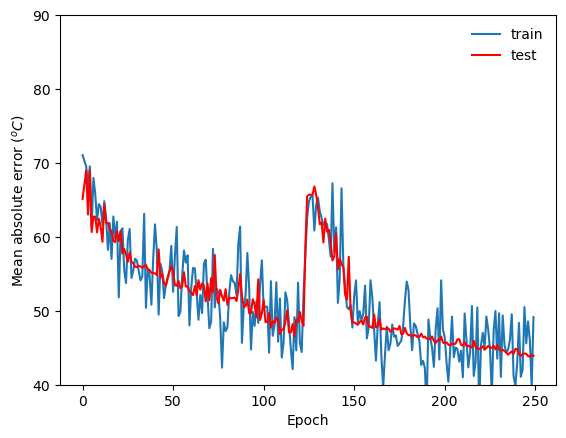

In [219]:
# plot cumulative train/test curves
temp = tt_train_20 + tt_train_130 + epoch200_train + epoch250_train
tt_tr = [x/128 for x in temp]
tt_te = tt_test_20 + tt_test_130 + epoch200_test + epoch250_test
xseries = np.arange(0, 250, 1)
plt.plot(xseries, smoother(tt_tr, win=5), label = "train")
plt.plot(xseries, smoother(tt_te, win=5), color='r', label = "test")
plt.xlabel("Epoch")
plt.ylabel("Mean absolute error ($^oC$)")
plt.legend(frameon = False)
plt.ylim([40, 90])
#plt.savefig("150epoch_32node.png", dpi=300)
plt.show()

Linear Regression

In [34]:
# convert all SMILES to 2048-bit molecular fingerprints using the RDKit built-in function
allmolecules = [Chem.MolFromSmiles(smiles) for smiles in tgs.iloc[:,0]]
fps = [Chem.RDKFingerprint(mol) for mol in allmolecules]

# initialize regression models
lr = LinearRegression()
brr = BayesianRidge()
rf = RandomForestRegressor()
pls = PLSRegression()

In [91]:
# set list of thresholds to test. The maximum variance per bit is around 0.24, so 0.23 was chosen as a maximum
thresholds = np.linspace(0, 0.23, num=24)

# initialize lists for storing the output (apparently this pre-allocates memory and is more efficient than list.append()?)
lr_mae = [0]*24
brr_mae = [0]*24
rf_mae = [0]*24
pls_mae = [0]*24

# filter fingerprints by threshold and fit regression models. 
for i in range(len(thresholds)):
    filtered = VarianceThreshold(threshold=float(thresholds[i])).fit_transform(fps)
    fp_train, fp_test, tg_train, tg_test = train_test_split(filtered, tgs.iloc[:,1], test_size=0.2, random_state=1234)
    lr.fit(fp_train, tg_train)
    brr.fit(fp_train, tg_train)
    rf.fit(fp_train, tg_train)
    pls.fit(fp_train, tg_train)

    # predict based on model and store MAE, R2
    lr_predict = lr.predict(fp_test)
    brr_predict = brr.predict(fp_test)
    rf_predict = rf.predict(fp_test)
    pls_predict = pls.predict(fp_test)
    lr_mae[i] = (mean_absolute_error(tg_test, lr_predict), r2_score(tg_test, lr_predict))
    brr_mae[i] = (mean_absolute_error(tg_test, brr_predict), r2_score(tg_test, brr_predict))
    rf_mae[i] = (mean_absolute_error(tg_test, rf_predict), r2_score(tg_test, rf_predict))
    pls_mae[i] = (mean_absolute_error(tg_test, pls_predict), r2_score(tg_test, pls_predict))

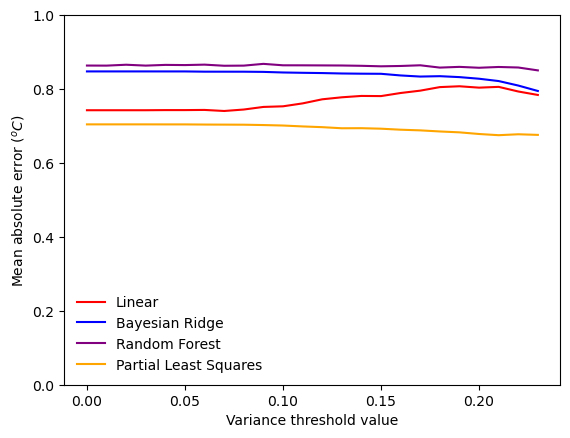

In [96]:
# unpack MAE, R2 values
maeL, r2L = zip(*lr_mae)
maeB, r2B = zip(*brr_mae)
maeR, r2R = zip(*rf_mae)
maeP, r2P = zip(*pls_mae)

plt.plot(thresholds, r2L, color='r', label="Linear")
plt.plot(thresholds, r2B, color='b', label = "Bayesian Ridge")
plt.plot(thresholds, r2R, color='purple', label = "Random Forest")
plt.plot(thresholds, r2P, color='orange', label = "Partial Least Squares")
plt.xlabel("Variance threshold value")
plt.ylabel("Mean absolute error ($^oC$)")
plt.ylim([0, 1])
plt.legend(frameon=False)
plt.show()

In [187]:
# evaluate random forest regression performance as a function of number of estimators
estimators = np.arange(32, 138, step=4)
#estimators = [100]
fp_train, fp_test, tg_train, tg_test = train_test_split(fps, tgs.iloc[:,1], test_size=0.2, random_state=1234)
randomforest = []

for estimator in estimators:
    rf = RandomForestRegressor(n_estimators=estimator)
    rf.fit(fp_train, tg_train)
    rf_predict = rf.predict(fp_test)
    randomforest.append([mean_absolute_error(tg_test, rf_predict), r2_score(tg_test, rf_predict)])


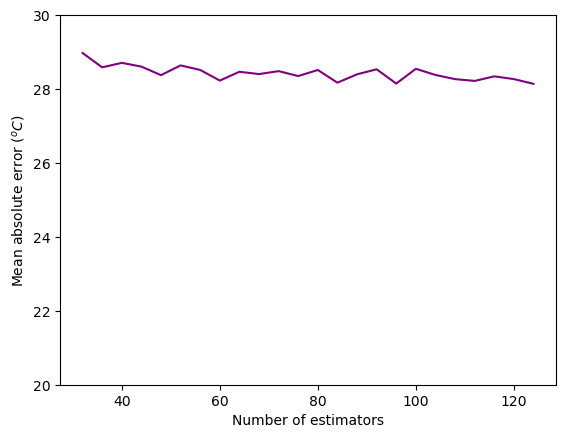

In [170]:
error_rand, _ = zip(*randomforest)
plt.plot(estimators, error_rand, color="purple")
plt.ylim([20,30])
plt.xlabel("Number of estimators")
plt.ylabel("Mean absolute error ($^oC$)")
plt.show()

Transfer Learning

In [117]:
# read peptoid dataset into GraphDataSet object. 35% of the data is reserved for testing due to the small number of total datapoints
peptoids = pd.read_excel("peptoid dataset.xlsx", header=0)
pep_tg = peptoids[peptoids['SMILES'].notnull()][["SMILES", "Tg"]]
pep_dataset = GraphDataSet(pep_tg, True, test_size=0.35)

<AxesSubplot:xlabel='Dataset', ylabel='T$_g$ ($^o$C)'>

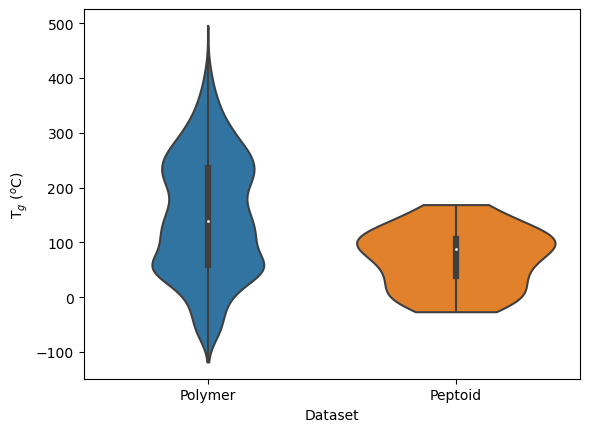

In [284]:
# Violin plot for comparing homopolymer and peptoid datasets
col1 = np.concatenate((tgs.iloc[:,1], pep_tg.iloc[:,1]))
col2 = ["Polymer"]*len(tgs.iloc[:,1]) + ["Peptoid"]*len(pep_tg.iloc[:,1])
plottingdf = pd.DataFrame({'T$_g$ ($^o$C)': col1, 'Dataset': col2})

sns.violinplot(x="Dataset", y="T$_g$ ($^o$C)", data=plottingdf, cut=0, scale="area")

In [255]:
# Transfer learning using pre-trained GNN. All parameters except learning rate and weight decay were kept the same
opt = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.02)
crit = torch.nn.SmoothL1Loss()
model.load_state_dict(torch.load("full32_epoch250.pt")) 

warnings.filterwarnings("ignore")
oneshot_train, oneshot_test, bestpep = train(model=model, optimizer=opt, criterion=crit, dataset=pep_dataset, batch_size=len(pep_dataset.Xtrain), epochs=100)

Epoch: 0, 	 Train r2: -1.3885 	 Train Loss: 1084.9878 	 Test r2: -0.3733 	 Test Loss 54.0497
Epoch: 2, 	 Train r2: -0.0324 	 Train Loss: 874.8611 	 Test r2: -0.6261 	 Test Loss 61.8643
Epoch: 4, 	 Train r2: 0.2585 	 Train Loss: 496.6086 	 Test r2: -0.4095 	 Test Loss 50.2732
Epoch: 6, 	 Train r2: 0.7090 	 Train Loss: 363.5865 	 Test r2: -0.0800 	 Test Loss 49.1012
Epoch: 8, 	 Train r2: 0.0693 	 Train Loss: 901.2214 	 Test r2: 0.0126 	 Test Loss 43.2426
Epoch: 10, 	 Train r2: 0.5227 	 Train Loss: 493.0406 	 Test r2: 0.2841 	 Test Loss 37.0718
Epoch: 12, 	 Train r2: 0.3702 	 Train Loss: 566.6568 	 Test r2: 0.4976 	 Test Loss 30.2023
Epoch: 14, 	 Train r2: 0.6501 	 Train Loss: 452.4725 	 Test r2: 0.6368 	 Test Loss 23.8390
Epoch: 16, 	 Train r2: 0.5320 	 Train Loss: 461.6790 	 Test r2: 0.6984 	 Test Loss 22.3856
Epoch: 18, 	 Train r2: 0.6779 	 Train Loss: 284.0517 	 Test r2: 0.6977 	 Test Loss 23.7393
Epoch: 20, 	 Train r2: 0.5808 	 Train Loss: 424.1876 	 Test r2: 0.7512 	 Test Loss 22.41

<All keys matched successfully>

In [265]:
# save model parameters after refinement
torch.save(model.state_dict(), "pep_final.pt")

In [261]:
oneshot = [float(model(point).detach()) for point in pep_dataset.Xtest]
print(mean_absolute_error(oneshot, pep_dataset.Ytest))
print(np.sqrt(mean_squared_error(oneshot, pep_dataset.Ytest)))

23.582854877818715
28.621802153988835


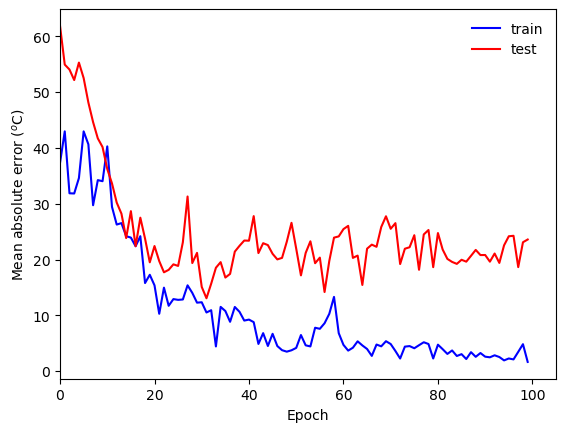

In [256]:
# plto train/test curves for few-shot transfer learning
averaged = [x/len(pep_dataset.Xtrain) for x in oneshot_train]

plt.plot(range(len(peptrain)), smoother(averaged, win=3), color='b', label="train")
plt.plot(range(len(peptest)), smoother(oneshot_test, win=3), color='r', label="test")
plt.xlabel("Epoch")
plt.ylabel("Mean absolute error ($^o$C)")
plt.xlim([0,105])
plt.legend(frameon=False)
plt.show()

In [189]:
# convert peptoid dataset to fingerprints
# perform zeroshot prediction first
allpep = [Chem.MolFromSmiles(smiles) for smiles in pep_tg.iloc[:,0]]
pepfp = [Chem.RDKFingerprint(mol) for mol in allpep]
zeroshot = rf.predict(pepfp)
print(r2_score(zeroshot, pep_tg.iloc[:,1]))
print(mean_absolute_error(zeroshot, pep_tg.iloc[:,1]))
print(np.sqrt(mean_squared_error(zeroshot, pep_tg.iloc[:,1])))

-3.115878317531674
58.695438218390805
68.99944252337377


In [197]:
# reuse the fitted RF regression model for refinement on peptoid training data
PXTrn, PXTest, PYTrn, PYTest = train_test_split(pepfp, pep_tg.iloc[:,1], test_size=0.35, random_state=1234)
rf_warm = RandomForestRegressor(warm_start=True)
rf_warm.fit(PXTrn, PYTrn)
fewshot = rf.predict(PXTest)
print(r2_score(fewshot, PYTest))
print(mean_absolute_error(fewshot, PYTest))
print(np.sqrt(mean_squared_error(fewshot, PYTest)))

-3.0333257796104247
38.2841462121212
46.14791062560793


Final evaluation

In [266]:
model.load_state_dict(torch.load("full32_epoch250.pt"))
predict_poly = [float(model(point).detach()) for point in poly_dataset.Xtest]

In [267]:
model.load_state_dict(torch.load("pep_final.pt"))
predict_pep = [float(model(point).detach()) for point in pep_dataset.Xtest]

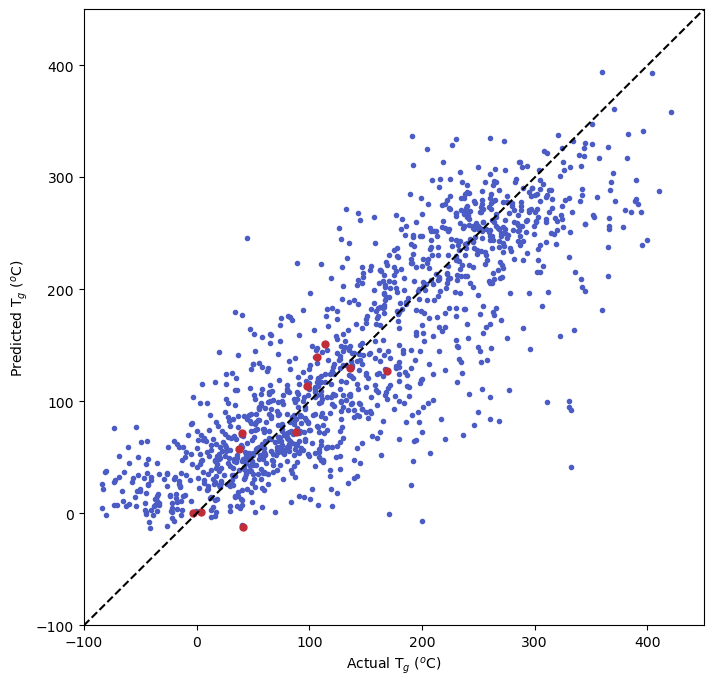

In [276]:
# scatterplot of actual vs predicted values
plt.figure(figsize=(8,8))
plt.plot(poly_dataset.Ytest, predict_poly, linestyle='none', color='#4b5cc4', marker=".", markersize=6)
plt.plot(pep_dataset.Ytest, predict_pep, linestyle='none', color='#c02c38', marker=".", markersize=10)
diag = np.arange(-100, 500, step=50)
plt.plot(diag, diag, "--k")
plt.xlim([-100, 450])
plt.ylim([-100, 450])
plt.xlabel("Actual T$_g$ ($^o$C)")
plt.ylabel("Predicted T$_g$ ($^o$C)")
#plt.savefig("RFpredictions.png", dpi=300)
plt.show()

In [277]:
rf_poly = rf.predict(fp_test)

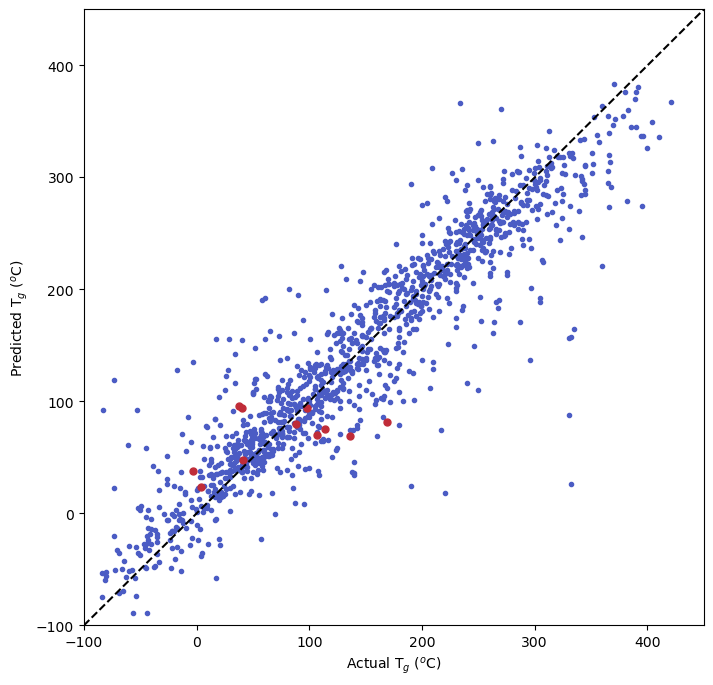

In [279]:
plt.figure(figsize=(8,8))
plt.plot(tg_test, rf_poly, linestyle='none', color='#4b5cc4', marker=".", markersize=6)
plt.plot(PYTest, fewshot, linestyle='none', color='#c02c38', marker=".", markersize=10)
diag = np.arange(-100, 500, step=50)
plt.plot(diag, diag, "--k")
plt.xlim([-100, 450])
plt.ylim([-100, 450])
plt.xlabel("Actual T$_g$ ($^o$C)")
plt.ylabel("Predicted T$_g$ ($^o$C)")
plt.savefig("RFpredictions.png", dpi=300)
plt.show()

In [281]:
r2_score(poly_dataset.Ytest, predict_poly)

0.7190094799838651